# ViT Transformer on CIFAR10 Dataset

## Libraries

In [36]:
import torch
import torchvision.datasets as datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms as tfs
from transformers import ViTForImageClassification, ViTConfig
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device) # cuda?

Device: cuda:0


## Scratch ViT Transformer Model

### Load Data and Augmentations

In [5]:
def set_seed(seed):
    '''
    Load a random seed
    '''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_data(download_data, batch_size, image_size):
    '''
    Download CIFAR-10 Dataset into train and test splits. Create dataloaders for data.
    '''
    print("Downloading Dataset...")
    
    train_transform = tfs.Compose([
        tfs.ToTensor(),
        tfs.RandomHorizontalFlip(),
        tfs.RandomCrop(32, padding=4),
        tfs.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        tfs.Resize((image_size, image_size))
    ]) 
    test_transform = tfs.Compose([
        tfs.ToTensor(),
        tfs.Resize((image_size, image_size)),
        tfs.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]) 
                                 
    data_train = datasets.CIFAR10(root='./data', train=True, download=download_data, transform=train_transform)
    data_test = datasets.CIFAR10(root='./data', train=False, download=download_data, transform=test_transform)
    
    train_loader = DataLoader(data_train, batch_size=batch_size,shuffle=True, num_workers=2)
    test_loader = DataLoader(data_test, batch_size=batch_size,shuffle=False, num_workers=2)
    print("Dataset Downloaded!")
    
    return train_loader, test_loader

### Define a basic ViT Model

Uses configurable ViT function from HuggingFace. Changed the input image size and output class size to fit CIFAR10 data and also made the model smaller (less hidden layers) to speed up training for smaller images.

In [10]:
def create_ViTModel():
    '''
    Smaller Version of ViT model with accomodations for CIFAR-10 data
    '''
    image_size = 32 # image size
    patch_size = 4 # patch size for encoding
    num_classes = 10 # num of classes
    
    #ViT model for CIFAR-10
    config = ViTConfig(
        image_size=image_size,  # Input image size
        patch_size=patch_size,  # Patch size for the 32x32 images
        num_labels=num_classes,  # Number of output classes
        hidden_size=256,  # Hidden size (smaller model for smaller images)
        num_hidden_layers=6,  # Fewer layers, since the image size is smaller
        num_attention_heads=8,  # Number of attention heads
        intermediate_size=512,  # Intermediate size of feedforward network
        hidden_dropout_prob=0.0,  # Dropout probability
        attention_probs_dropout_prob=0.0,  # Dropout on attention scores
    )
    
    model = ViTForImageClassification(config)
    
    return model

### Train and Test Model Functions

In [28]:
def train_model(train_data, test_data, model, optimizer, criterion, epochs):
    print("Starting Training...")
    model.train()
    batch_losses = []
    epoch_losses = []
    test_accuracies = []
    num_batches = len(train_data) # num of batches per epoch
    
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in tqdm(enumerate(train_data)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output.logits, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() #running loss for epoch loss            
                
        print(f'Epoch: {epoch + 1}, Average Training Loss: {running_loss/num_batches}' )
        # get average loss over epoch (scratch only)
        epoch_losses.append([epoch, running_loss/num_batches])
        accuracy, _ = test_model(test_data, model)
        test_accuracies.append(accuracy)
    
    print("Finished Training!")
    return model, batch_losses, epoch_losses, test_accuracies

In [27]:
def test_model(test_data, model):
    print("Testing Model...")
    correct = 0
    predictions = []
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_data)):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.logits, 1)
            predictions.append(predicted)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / 10000
    print(f'Test Accuracy: {accuracy}%' )
    
    return accuracy, predictions

In [72]:
# confusion matrix creator
def confusion_matrix(classes, predicted_vals, test_data):
    num_classes = len(classes)
    actuals = []
    predictions = []
    #need to unroll dataloader and predictions
    for idx, (_, labels) in enumerate(test_data):
        actuals.extend(labels.tolist())
        predictions.extend(predicted_vals[idx])

    #create matrix
    mat = np.zeros((num_classes, num_classes))
    #print(len(predictions), len(actuals))
    for prediction, actual in zip(predictions, actuals):
        mat[prediction,actual] += 1

    #plot matrix
    fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 10))
    ax1.matshow(mat)
    
    # add the title and label
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Actual Class')
    ax1.set_ylabel('Predicted Class')
    # set ticks to the classes
    ax1.set_xticks(np.arange(num_classes), labels=classes)
    ax1.set_yticks(np.arange(num_classes), labels=classes)

    for x in range(num_classes):
        for y in range(num_classes):
            ax1.annotate(int(mat[x,y]),xy=(x-0.2,y+0.1))
            


### Run Training from scratch model

In [42]:
# Get dataloaders
batch_size = 100
image_size = 32
# set download data to true if not downloaded already
train_loader, test_loader = get_data(download_data = False, batch_size = batch_size, image_size = image_size)

Dataset Downloaded!


In [14]:
# Main 
# set the random seed
seed = 42
set_seed(seed)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# hyperparameters
epochs = 40
lr = 1e-4
#model
model = create_ViTModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam 
criterion = nn.CrossEntropyLoss() 
# run training
trained_model, batch_losses, epoch_losses, test_accuracies = train_model(train_loader, test_loader, model, optimizer, criterion, epochs)

Starting Training...


0it [00:00, ?it/s]C:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\transformers\models\vit\modeling_vit.py:252: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
500it [00:52,  9.49it/s]


Epoch: 1, Average Training Loss: 1.7788601195812226
Testing Model...


100it [00:03, 27.95it/s]


Test Accuracy: 41.12%


500it [00:46, 10.79it/s]


Epoch: 2, Average Training Loss: 1.435203596830368
Testing Model...


100it [00:03, 28.85it/s]


Test Accuracy: 51.06%


500it [00:47, 10.57it/s]


Epoch: 3, Average Training Loss: 1.2614979430437088
Testing Model...


100it [00:03, 28.59it/s]


Test Accuracy: 57.0%


500it [00:48, 10.37it/s]


Epoch: 4, Average Training Loss: 1.1591008551120758
Testing Model...


100it [00:03, 25.28it/s]


Test Accuracy: 57.42%


500it [00:49, 10.19it/s]


Epoch: 5, Average Training Loss: 1.085102244734764
Testing Model...


100it [00:03, 28.18it/s]


Test Accuracy: 62.07%


500it [00:47, 10.46it/s]


Epoch: 6, Average Training Loss: 1.0219123470783233
Testing Model...


100it [00:03, 28.73it/s]


Test Accuracy: 64.83%


500it [00:48, 10.33it/s]


Epoch: 7, Average Training Loss: 0.9738837976455689
Testing Model...


100it [00:03, 26.68it/s]


Test Accuracy: 67.73%


500it [00:49, 10.19it/s]


Epoch: 8, Average Training Loss: 0.9227694236040115
Testing Model...


100it [00:03, 27.12it/s]


Test Accuracy: 67.2%


500it [00:49, 10.01it/s]


Epoch: 9, Average Training Loss: 0.8707098126411438
Testing Model...


100it [00:03, 27.48it/s]


Test Accuracy: 68.93%


500it [00:49, 10.02it/s]


Epoch: 10, Average Training Loss: 0.8369457297325135
Testing Model...


100it [00:03, 26.90it/s]


Test Accuracy: 70.75%


500it [00:49, 10.04it/s]


Epoch: 11, Average Training Loss: 0.8038960976600646
Testing Model...


100it [00:03, 25.89it/s]


Test Accuracy: 71.57%


500it [00:50,  9.89it/s]


Epoch: 12, Average Training Loss: 0.7656584465503693
Testing Model...


100it [00:03, 26.58it/s]


Test Accuracy: 72.14%


500it [00:51,  9.68it/s]


Epoch: 13, Average Training Loss: 0.7427107385396957
Testing Model...


100it [00:03, 28.20it/s]


Test Accuracy: 72.68%


500it [00:53,  9.38it/s]


Epoch: 14, Average Training Loss: 0.7063895908594131
Testing Model...


100it [00:03, 27.49it/s]


Test Accuracy: 74.9%


500it [00:54,  9.25it/s]


Epoch: 15, Average Training Loss: 0.690698114156723
Testing Model...


100it [00:03, 27.23it/s]


Test Accuracy: 72.99%


500it [00:53,  9.36it/s]


Epoch: 16, Average Training Loss: 0.6682174343466759
Testing Model...


100it [00:03, 28.15it/s]


Test Accuracy: 74.29%


500it [00:51,  9.76it/s]


Epoch: 17, Average Training Loss: 0.6441955996155739
Testing Model...


100it [00:03, 27.21it/s]


Test Accuracy: 76.23%


500it [00:52,  9.59it/s]


Epoch: 18, Average Training Loss: 0.6212761876583099
Testing Model...


100it [00:03, 27.39it/s]


Test Accuracy: 76.67%


500it [00:51,  9.80it/s]


Epoch: 19, Average Training Loss: 0.6002607713341713
Testing Model...


100it [00:03, 27.89it/s]


Test Accuracy: 76.96%


500it [00:51,  9.62it/s]


Epoch: 20, Average Training Loss: 0.5841266531944275
Testing Model...


100it [00:03, 27.16it/s]


Test Accuracy: 76.45%


500it [00:52,  9.51it/s]


Epoch: 21, Average Training Loss: 0.5661093810200691
Testing Model...


100it [00:03, 26.83it/s]


Test Accuracy: 76.92%


500it [00:51,  9.78it/s]


Epoch: 22, Average Training Loss: 0.5443105479478836
Testing Model...


100it [00:03, 28.08it/s]


Test Accuracy: 77.88%


500it [00:50,  9.94it/s]


Epoch: 23, Average Training Loss: 0.5297250992059708
Testing Model...


100it [00:03, 28.26it/s]


Test Accuracy: 77.72%


500it [00:50,  9.94it/s]


Epoch: 24, Average Training Loss: 0.508626264065504
Testing Model...


100it [00:03, 27.32it/s]


Test Accuracy: 78.63%


500it [00:50,  9.92it/s]


Epoch: 25, Average Training Loss: 0.4941293298602104
Testing Model...


100it [00:03, 27.79it/s]


Test Accuracy: 78.43%


500it [00:51,  9.79it/s]


Epoch: 26, Average Training Loss: 0.4798332377076149
Testing Model...


100it [00:03, 26.30it/s]


Test Accuracy: 76.42%


500it [00:49, 10.01it/s]


Epoch: 27, Average Training Loss: 0.4567517488002777
Testing Model...


100it [00:03, 27.09it/s]


Test Accuracy: 78.3%


500it [00:51,  9.63it/s]


Epoch: 28, Average Training Loss: 0.45092562824487686
Testing Model...


100it [00:03, 27.04it/s]


Test Accuracy: 79.68%


500it [00:50,  9.93it/s]


Epoch: 29, Average Training Loss: 0.42978142020106314
Testing Model...


100it [00:03, 28.96it/s]


Test Accuracy: 79.91%


500it [00:50,  9.99it/s]


Epoch: 30, Average Training Loss: 0.4150242710709572
Testing Model...


100it [00:03, 28.85it/s]


Test Accuracy: 78.54%


500it [00:48, 10.25it/s]


Epoch: 31, Average Training Loss: 0.4032616263628006
Testing Model...


100it [00:03, 29.13it/s]


Test Accuracy: 79.59%


500it [00:48, 10.27it/s]


Epoch: 32, Average Training Loss: 0.3846920526623726
Testing Model...


100it [00:03, 28.74it/s]


Test Accuracy: 79.23%


500it [00:48, 10.28it/s]


Epoch: 33, Average Training Loss: 0.373200883358717
Testing Model...


100it [00:03, 29.44it/s]


Test Accuracy: 79.59%


500it [00:48, 10.40it/s]


Epoch: 34, Average Training Loss: 0.3589352248311043
Testing Model...


100it [00:03, 29.63it/s]


Test Accuracy: 79.81%


500it [00:48, 10.41it/s]


Epoch: 35, Average Training Loss: 0.3420868677794933
Testing Model...


100it [00:03, 29.40it/s]


Test Accuracy: 79.62%


500it [00:47, 10.43it/s]


Epoch: 36, Average Training Loss: 0.329080348521471
Testing Model...


100it [00:03, 28.49it/s]


Test Accuracy: 79.83%


500it [00:48, 10.40it/s]


Epoch: 37, Average Training Loss: 0.3167169889509678
Testing Model...


100it [00:03, 28.53it/s]


Test Accuracy: 79.95%


500it [00:47, 10.57it/s]


Epoch: 38, Average Training Loss: 0.30500979387760163
Testing Model...


100it [00:03, 28.88it/s]


Test Accuracy: 80.4%


500it [00:47, 10.58it/s]


Epoch: 39, Average Training Loss: 0.2922238664329052
Testing Model...


100it [00:03, 28.08it/s]


Test Accuracy: 80.23%


500it [00:47, 10.42it/s]


Epoch: 40, Average Training Loss: 0.2737396823167801
Testing Model...


100it [00:03, 28.39it/s]

Test Accuracy: 80.14%
Finished Training!


### Evaluate Model

Run test set on trained model and get loss and accuracy plots

In [43]:
# evaluate model on test set
final_accuracy, predictions = test_model(test_loader, trained_model)

Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 80.14%


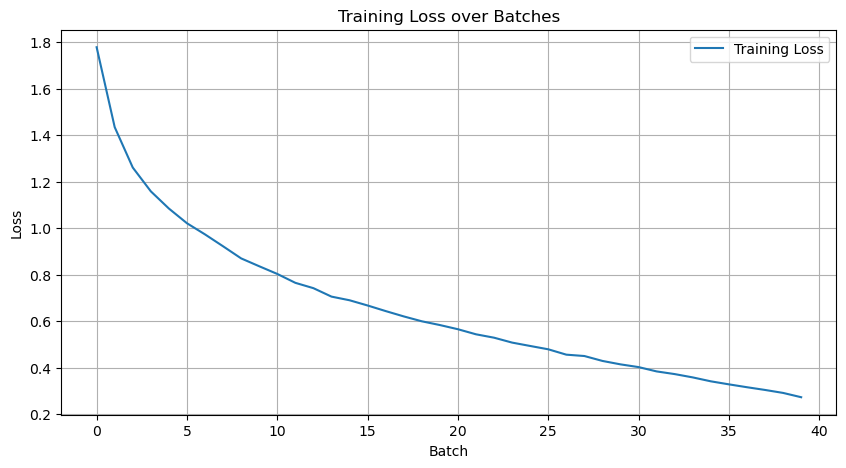

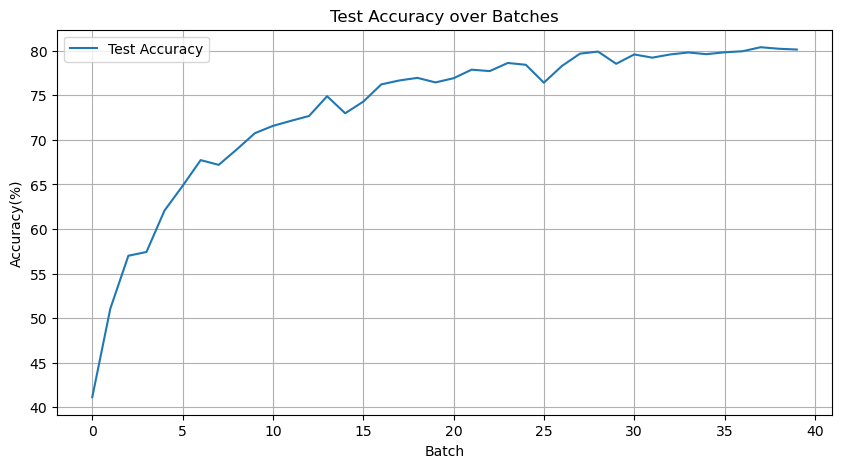

In [19]:
#Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(epoch_losses)[:,0], np.array(epoch_losses)[:,1], label='Training Loss')
plt.title('Training Loss over Batches')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.array(epoch_losses)[:,0], np.array(test_accuracies), label='Test Accuracy')
plt.title('Test Accuracy over Batches')
plt.xlabel('Batch')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.grid(True)
plt.show()


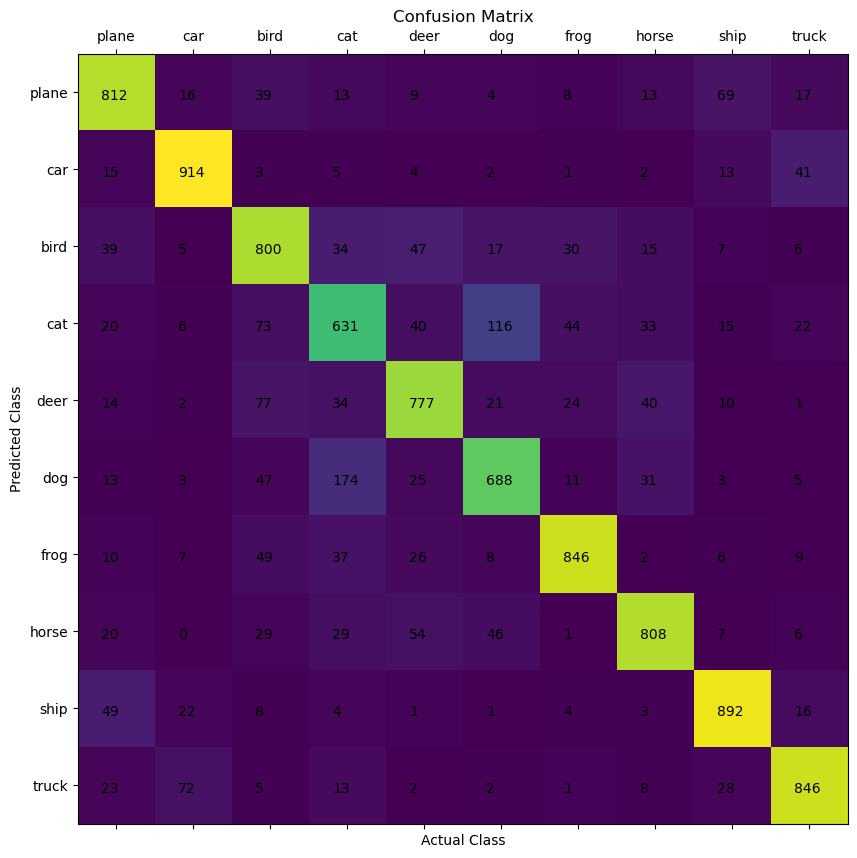

In [73]:
# Confusion matrix
confusion_matrix(classes, predictions, test_loader)

## Pre-Trained ViT Transformer Model

### Run training for pre-trained ViT Model

Use HuggingFace to load the tiny ViT model from its paper with its weights trained on ImageNet

In [30]:
# training for pretrained
def train_model(train_data, test_data, model, optimizer, criterion, epochs):
    print("Starting Training...")
    model.train()
    batch_losses = []
    epoch_losses = []
    test_accuracies = []
    num_batches = len(train_data) # num of batches per epoch
    
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in tqdm(enumerate(train_data)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output.logits, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() #running loss for epoch loss

            # Output batch loss every 100 epochs (pretrained only)
            if (batch_idx) % 100 == 0:
                total_batch = (batch_idx+1 + (epoch)*num_batches) # batch number over epochs
                # print batch loss
                print(f'Batch {batch_idx} Loss: {loss.item()}')
                batch_losses.append([total_batch, loss.item()])
                # Get test accuracy at this step
                accuracy, _ = test_model(test_data, model)
                test_accuracies.append(accuracy)
                
        print(f'Epoch: {epoch + 1}, Average Training Loss: {running_loss/num_batches}' )
    
    print("Finished Training!")
    return model, batch_losses, epoch_losses, test_accuracies

In [31]:
# pre trained tiny ViT weights but remove the last layer and output to the 10 CIFAR classes
model = ViTForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224",num_labels=10, ignore_mismatched_sizes=True).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
# Get dataloaders
batch_size = 20
image_size = 224
# set download data to true if not downloaded already
train_loader, test_loader = get_data(download_data = False, batch_size = batch_size, image_size = image_size)

Dataset Downloaded!


In [37]:
# Main 
# set the random seed
seed = 42
set_seed(seed)
# hyperparameters
epochs = 2   
lr = 3e-6
#model
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam 
criterion = nn.CrossEntropyLoss() 
# run training
trained_model_pre, batch_losses_pre, epoch_losses_pre, test_accuracies_pre = train_model(train_loader, test_loader, model, optimizer, criterion, epochs)

Starting Training...


0it [00:00, ?it/s]

Batch 0 Loss: 3.1816375255584717
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 10.57%
Batch 100 Loss: 2.0676722526550293
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 20.62%
Batch 200 Loss: 1.625948190689087
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 38.09%
Batch 300 Loss: 1.2630597352981567
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 51.59%
Batch 400 Loss: 1.2550604343414307
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 60.19%
Batch 500 Loss: 1.3294166326522827
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 66.52%
Batch 600 Loss: 0.8406277894973755
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 72.21%
Batch 700 Loss: 0.7879771590232849
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 76.49%
Batch 800 Loss: 0.5929625034332275
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 80.25%
Batch 900 Loss: 0.5490941405296326
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 82.41%
Batch 1000 Loss: 0.561109721660614
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 84.34%
Batch 1100 Loss: 0.28445863723754883
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 85.3%
Batch 1200 Loss: 0.8019267320632935
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 86.29%
Batch 1300 Loss: 0.3638841211795807
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 87.29%
Batch 1400 Loss: 0.6054552793502808
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 88.2%
Batch 1500 Loss: 0.4908858835697174
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 88.78%
Batch 1600 Loss: 0.3094870150089264
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 89.35%
Batch 1700 Loss: 0.21031565964221954
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 89.61%
Batch 1800 Loss: 0.16568966209888458
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 90.43%
Batch 1900 Loss: 0.3711242973804474
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 90.72%
Batch 2000 Loss: 0.6341031789779663
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 90.89%
Batch 2100 Loss: 0.26791831851005554
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 91.25%
Batch 2200 Loss: 0.3619423806667328
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 91.16%
Batch 2300 Loss: 0.24103376269340515
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 91.63%
Batch 2400 Loss: 0.269955575466156
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 91.72%
Epoch: 1, Average Training Loss: 0.6923772946491837


0it [00:00, ?it/s]

Batch 0 Loss: 0.15707948803901672
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 91.9%
Batch 100 Loss: 0.2866450250148773
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 92.29%
Batch 200 Loss: 0.2099359780550003
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 92.43%
Batch 300 Loss: 0.03496967628598213
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 91.98%
Batch 400 Loss: 0.056753724813461304
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 92.91%
Batch 500 Loss: 0.15175610780715942
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 92.71%
Batch 600 Loss: 0.22722463309764862
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 92.81%
Batch 700 Loss: 0.06231041997671127
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 93.41%
Batch 800 Loss: 0.36001482605934143
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 92.97%
Batch 900 Loss: 0.08115354925394058
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 93.34%
Batch 1000 Loss: 0.26975205540657043
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 93.4%
Batch 1100 Loss: 0.3580533564090729
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 93.85%
Batch 1200 Loss: 0.1766705960035324
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 93.66%
Batch 1300 Loss: 0.22027289867401123
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 93.46%
Batch 1400 Loss: 0.32969170808792114
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 94.03%
Batch 1500 Loss: 0.15669527649879456
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 93.41%
Batch 1600 Loss: 0.08075468242168427
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 94.28%
Batch 1700 Loss: 0.20683734118938446
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 93.78%
Batch 1800 Loss: 0.23054750263690948
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 94.0%
Batch 1900 Loss: 0.06133809685707092
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 94.3%
Batch 2000 Loss: 0.5244377255439758
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 94.21%
Batch 2100 Loss: 0.20865733921527863
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 94.62%
Batch 2200 Loss: 0.047859370708465576
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 94.06%
Batch 2300 Loss: 0.41884297132492065
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 93.94%
Batch 2400 Loss: 0.1189035177230835
Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 94.64%
Epoch: 2, Average Training Loss: 0.18352451479770243
Finished Training!


### Evaluate Model

Run test set on trained model and get loss and accuracy plots

In [39]:
# evaluate model on test set
final_accuracy_pre, predictions_pre = test_model(test_loader, trained_model_pre)

Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 94.49%


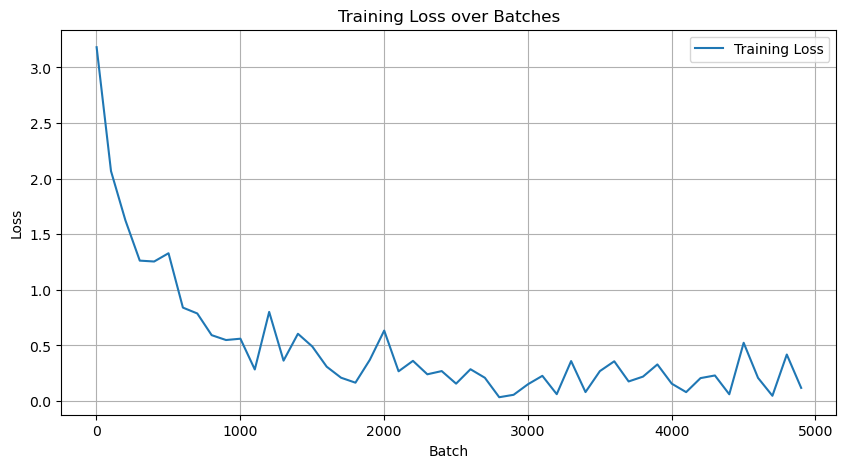

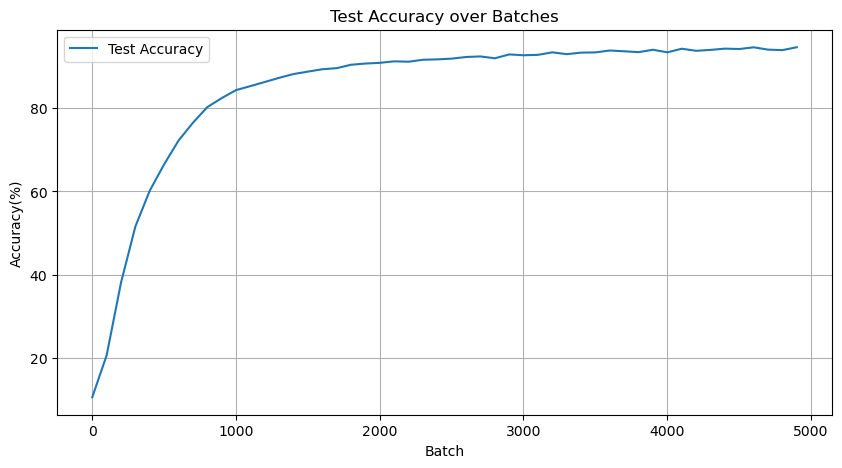

In [40]:
#Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(batch_losses_pre)[:,0], np.array(batch_losses_pre)[:,1], label='Training Loss')
plt.title('Training Loss over Batches')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.array(batch_losses_pre)[:,0], np.array(test_accuracies_pre), label='Test Accuracy')
plt.title('Test Accuracy over Batches')
plt.xlabel('Batch')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.grid(True)
plt.show()


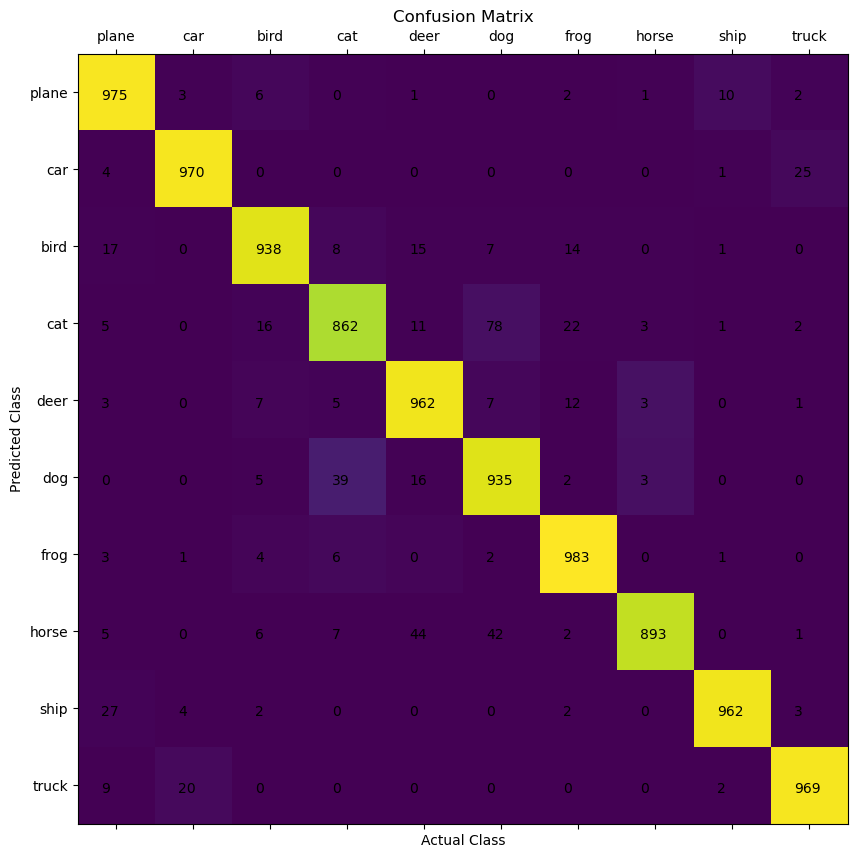

In [75]:
# Confusion matrix
confusion_matrix(classes, predictions_pre, test_loader)